# Chapter 8 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from scipy import stats
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Constants

In [2]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"
RUGGED_FILE = "rugged.csv"
TULIPS_FILE = "tulips.csv"

RANDOM_SEED = 42

### Defaults

In [3]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

# set seed
rng = np.random.default_rng(RANDOM_SEED)

### Functions

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

In [5]:
def smooth_plot_data(x, y, smooth_kwargs=None):
    if smooth_kwargs is None:
        smooth_kwargs = {}

    smooth_kwargs.setdefault("window_length", 55)
    smooth_kwargs.setdefault("polyorder", 2)
    x_data = np.linspace(x.min(), x.max(), 200)
    x_data[0] = (x_data[0] + x_data[1]) / 2
    y_interp = griddata(x, y, x_data)
    y_data = savgol_filter(y_interp, axis=0, **smooth_kwargs)

    return x_data, y_data

## 8.1 Building an interaction

### 8.1.1 Making a rugged model

In [6]:
# load the data
rugged = load_data(RUGGED_FILE, delimiter=";")

# define log gdp
rugged["log_gdp"] = np.log(rugged["rgdppc_2000"])

# restrict to countries with gdp data
rugged = rugged.dropna(subset=["rgdppc_2000"])

# standardise variables
rugged["log_gdp_std"] = rugged["log_gdp"] / rugged["log_gdp"].mean()
rugged["rugged_std"] = rugged["rugged"] / rugged["rugged"].max()

Define a first model with rough priors

In [7]:
coords = {
    "country": rugged.country,
}
with pm.Model(coords_mutable=coords) as m8_1a:
    # data
    rugged_std = pm.MutableData("rugged_std", rugged.rugged_std, dims="country")
    rugged_std_mean = pm.MutableData("rugged_std_mean", rugged.rugged_std.mean())

    # priors
    alpha = pm.Normal("alpha", mu=1, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta * (rugged_std - rugged_std_mean), dims="country"
    )

    # likelihood
    log_gdp_std = pm.Normal(
        "log_gdp_std", mu=mu, sigma=sigma, observed=rugged.log_gdp_std, dims="country"
    )

    # sample prior predictive
    prior_trace_8_1a = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta, log_gdp_std, sigma]


In [8]:
m8_1a

      alpha ~ Normal(1, 1)
       beta ~ Normal(0, 1)
      sigma ~ Exponential(f())
         mu ~ Deterministic(f(alpha, beta))
log_gdp_std ~ Normal(mu, sigma)

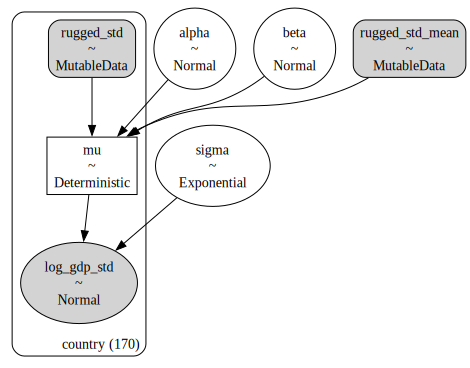

In [9]:
m8_1a.to_graphviz()

And now with some better priors

In [10]:
coords = {
    "country": rugged.country,
}
with pm.Model(coords_mutable=coords) as m8_1b:
    # data
    rugged_std = pm.MutableData("rugged_std", rugged.rugged_std, dims="country")
    rugged_std_mean = pm.MutableData("rugged_std_mean", rugged.rugged_std.mean())

    # priors
    alpha = pm.Normal("alpha", mu=1, sigma=0.1)
    beta = pm.Normal("beta", mu=0, sigma=0.3)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta * (rugged_std - rugged_std_mean), dims="country"
    )

    # likelihood
    log_gdp_std = pm.Normal(
        "log_gdp_std", mu=mu, sigma=sigma, observed=rugged.log_gdp_std, dims="country"
    )

    # sample prior predictive
    prior_trace_8_1b = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta, log_gdp_std, sigma]


In [11]:
m8_1b

      alpha ~ Normal(1, 0.1)
       beta ~ Normal(0, 0.3)
      sigma ~ Exponential(f())
         mu ~ Deterministic(f(alpha, beta))
log_gdp_std ~ Normal(mu, sigma)

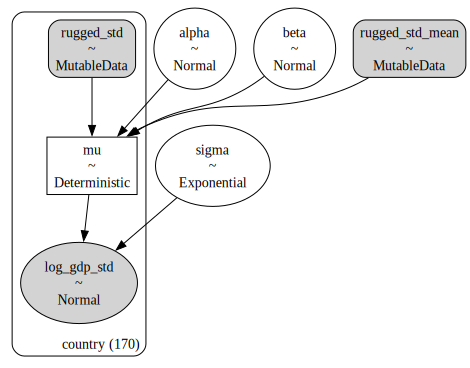

In [12]:
m8_1b.to_graphviz()

Let's plot some sample prior means

In [13]:
def plot_sample_prior_lines(trace, n_lines=50, ylim=None, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    if ylim is None:
        ylim = [0.5, 1.5]
    if title is None:
        title = "Sample prior means"

    x_val = trace.constant_data.rugged_std.data
    ax.plot(
        np.repeat(x_val[:, np.newaxis], n_lines, axis=1),
        trace.prior.mu.isel(chain=0, draw=slice(n_lines)).T,
        color="k",
        alpha=0.2,
    )

    min_log_gdp_std = trace.observed_data.log_gdp_std.min()
    ax.axhline(min_log_gdp_std, color="k", ls="--")

    max_log_gdp_std = trace.observed_data.log_gdp_std.max()
    ax.axhline(max_log_gdp_std, color="k", ls="--")

    ax.set(
        ylim=ylim,
        xlabel="Ruggedness",
        ylabel="Log GDP (proportion of mean)",
        title=title,
    )

    return ax

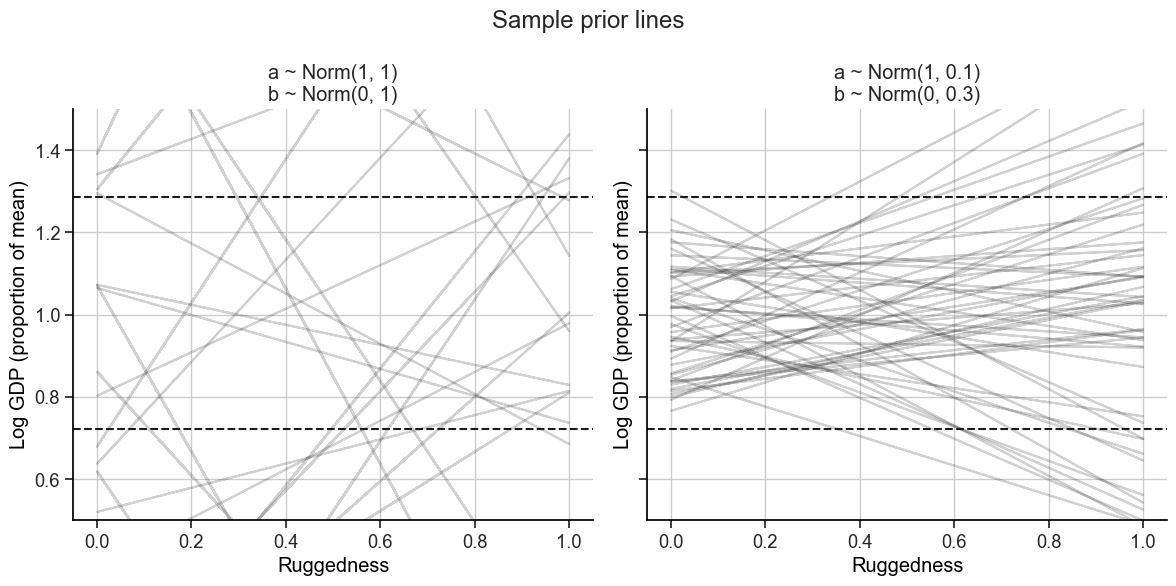

In [14]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

plot_sample_prior_lines(
    prior_trace_8_1a, title="a ~ Norm(1, 1)\nb ~ Norm(0, 1)", ax=axs[0]
)
plot_sample_prior_lines(
    prior_trace_8_1b, title="a ~ Norm(1, 0.1)\nb ~ Norm(0, 0.3)", ax=axs[1]
)

fig.suptitle("Sample prior lines")
fig.tight_layout();

Now let's look at the posterior

In [15]:
with m8_1b:
    trace_8_1b = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [16]:
az.summary(
    trace_8_1b,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,1.00,0.01,0.98,1.02
beta,0.00,0.06,-0.09,0.10
sigma,0.14,0.01,0.13,0.15


The slope - beta - is zero, showing no relationship.

### 8.1.2 Adding an indicator variable isn't enough

Let's add a separate slope for Africa

In [17]:
continents = [
    "Not Africa",
    "Africa",
]

rugged["continent"] = np.where(
    rugged["cont_africa"] == 1,
    "Africa",
    "Not Africa",
)
continents_idx_mapper = {
    "Not Africa": 0,
    "Africa": 1,
}

coords = {
    "country": rugged.country,
    "continent": continents,
}
with pm.Model(coords_mutable=coords) as m8_2:
    # data
    rugged_std = pm.MutableData("rugged_std", rugged.rugged_std, dims="country")
    rugged_std_mean = pm.MutableData("rugged_std_mean", rugged.rugged_std.mean())
    continent_idx = pm.MutableData("continent_idx", rugged.cont_africa, dims="country")

    # priors
    alpha = pm.Normal("alpha", mu=1, sigma=0.1, dims="continent")
    beta = pm.Normal("beta", mu=0, sigma=0.3)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[continent_idx] + beta * (rugged_std - rugged_std_mean),
        dims="country",
    )

    # likelihood
    log_gdp_std = pm.Normal(
        "log_gdp_std", mu=mu, sigma=sigma, observed=rugged.log_gdp_std, dims="country"
    )

    # sample prior predictive
    trace_8_2 = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


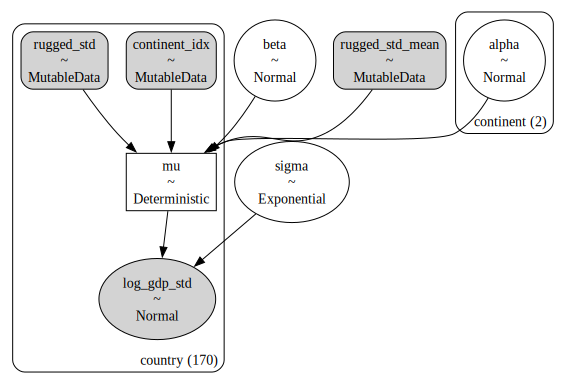

In [18]:
m8_2.to_graphviz()

In [19]:
with m8_1b:
    pm.compute_log_likelihood(trace_8_1b)

In [20]:
az.compare(
    {
        "m8.1": trace_8_1b,
        "m8.2": trace_8_2,
    },
    ic="waic",
    scale="deviance",
)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.2,0,-252.224855,4.178578,0.000000,0.968637,14.834728,0.000000,True,deviance
m8.1,1,-188.795587,2.610492,63.429268,0.031363,12.969212,14.688577,False,deviance


In [21]:
az.compare(
    {
        "m8.1": trace_8_1b,
        "m8.2": trace_8_2,
    },
    ic="loo",
    scale="deviance",
)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m8.2,0,-252.191723,4.195144,0.000000,0.968434,14.841186,0.000000,False,deviance
m8.1,1,-188.781757,2.617406,63.409966,0.031566,12.970321,14.693603,False,deviance


Why am I getting warnings for model 8.1?

Let's look at the individual PSIS and WAIC values.

In [22]:
psis_8_2 = az.loo(trace_8_2, scale="deviance", pointwise=True)
waic_8_2 = az.waic(trace_8_2, scale="deviance", pointwise=True)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [23]:
psis_8_2

Computed from 4000 posterior samples and 170 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  -252.19    14.84
p_loo            4.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      170  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

I don't get any warnings from PSIS.

But plotting the values I can see a pretty extreme WAIC value

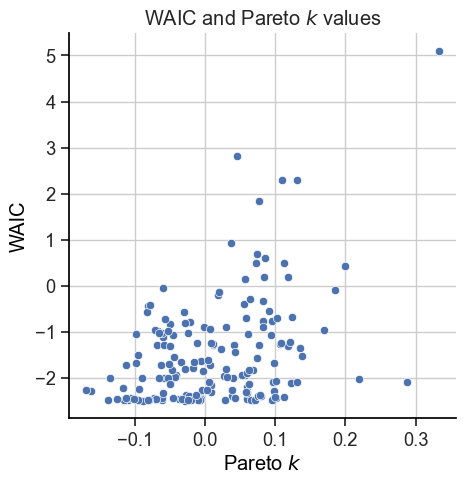

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    x=psis_8_2.pareto_k,
    y=waic_8_2.waic_i,
    ax=ax,
)

ax.set(
    xlabel="Pareto $k$",
    ylabel="WAIC",
    title="WAIC and Pareto $k$ values",
);

What's this outlier?

In [25]:
trace_8_2.constant_data.isel(country=waic_8_2.waic_i.argmax())

<xarray.Dataset>
Dimensions:          ()
Coordinates:
    country          <U52 'Seychelles'
Data variables:
    rugged_std       float64 0.7876
    rugged_std_mean  float64 0.215
    continent_idx    int32 1
Attributes:
    created_at:                 2024-07-26T15:10:48.834077
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

It looks like the Seychelles.
Inspecting the scatterplot this is the African point at the top right - it's easy to see why this would have a large effect on the model fit.

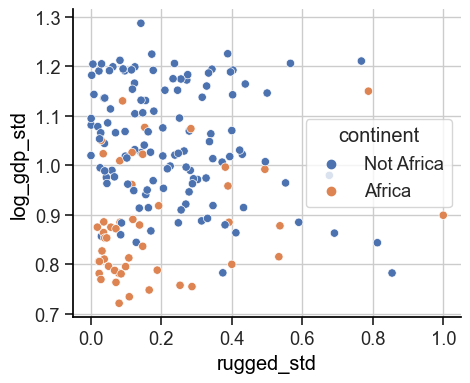

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(
    rugged,
    x="rugged_std",
    y="log_gdp_std",
    hue="continent",
    hue_order=continents,
    ax=ax,
);

Now let's look at the new model's posterior

In [27]:
az.summary(
    trace_8_2,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[Not Africa],1.05,0.01,1.03,1.07
alpha[Africa],0.88,0.02,0.86,0.91
beta,-0.05,0.05,-0.12,0.03
sigma,0.11,0.01,0.10,0.12


The intercepts are noticeably different.

Let's plot the posterior predictive intervals.

In [28]:
# generate counterfactual ruggedness values
n_vals = 100
rugged_std_vals = np.linspace(0, 1, n_vals)

counterfactual_trace_8_2 = dict.fromkeys(continents)
with m8_2:
    for continent, continent_idx in continents_idx_mapper.items():
        pm.set_data(
            {
                "rugged_std": rugged_std_vals,
                "continent_idx": np.full(n_vals, continent_idx, dtype=int),
            },
            coords={
                "country": range(n_vals),
            },
        )
        counterfactual_trace_8_2[continent] = pm.sample_posterior_predictive(
            trace_8_2,
            var_names=["mu", "log_gdp_std"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

Sampling: [log_gdp_std]


Sampling: [log_gdp_std]


In [29]:
def plot_posterior_linear_model(
    x, mu, hdi_prob=0.89, smooth=True, smooth_kwargs=None, color=None, ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    # plot mu
    mu_mean = mu.mean(dim=["chain", "draw"])
    if smooth:
        x_plot, mu_mean = smooth_plot_data(x, mu_mean, smooth_kwargs)
    ax.plot(
        x_plot,
        mu_mean,
        color=color,
    )

    # plot hdi around mu
    mu_hdi = az.hdi(mu, hdi_prob=hdi_prob).mu
    if smooth:
        x_plot, mu_hdi = smooth_plot_data(x, mu_hdi, smooth_kwargs)

    ax.fill_between(
        x_plot,
        mu_hdi[:, 0],
        mu_hdi[:, 1],
        color=color,
        alpha=0.3,
    )

    return ax

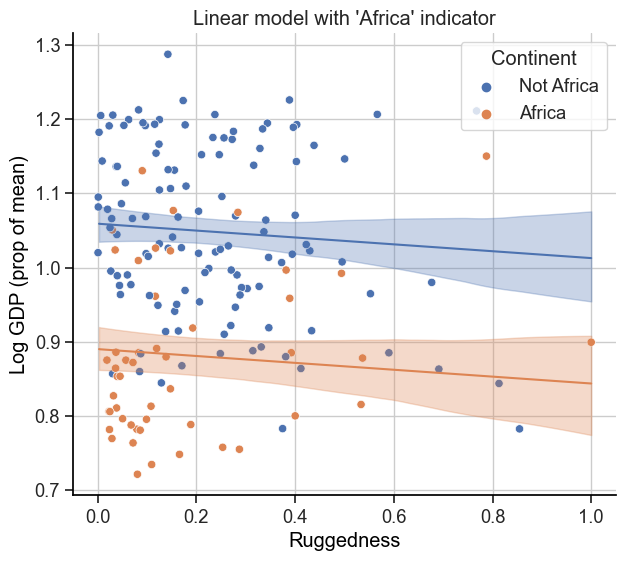

In [30]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.scatterplot(
    rugged,
    x="rugged_std",
    y="log_gdp_std",
    hue="continent",
    hue_order=continents,
    ax=ax,
)

for idx, (continent, trace) in enumerate(counterfactual_trace_8_2.items()):
    plot_posterior_linear_model(
        x=trace.predictions_constant_data.rugged_std,
        mu=trace.predictions.mu,
        smooth=True,
        color=colors[idx],
        ax=ax,
    )

ax.set(
    xlabel="Ruggedness",
    ylabel="Log GDP (prop of mean)",
    title="Linear model with 'Africa' indicator",
)
ax.legend(title="Continent");

### 8.1.3 Adding an interaction does work

Now add an interaction term to the model

In [31]:
coords = {
    "country": rugged.country,
    "continent": continents,
}
with pm.Model(coords_mutable=coords) as m8_3:
    # data
    rugged_std = pm.MutableData("rugged_std", rugged.rugged_std, dims="country")
    rugged_std_mean = pm.MutableData("rugged_std_mean", rugged.rugged_std.mean())
    continent_idx = pm.MutableData("continent_idx", rugged.cont_africa, dims="country")

    # priors
    alpha = pm.Normal("alpha", mu=1, sigma=0.1, dims="continent")
    beta = pm.Normal("beta", mu=0, sigma=0.3, dims="continent")
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[continent_idx] + beta[continent_idx] * (rugged_std - rugged_std_mean),
        dims="country",
    )

    # likelihood
    log_gdp_std = pm.Normal(
        "log_gdp_std", mu=mu, sigma=sigma, observed=rugged.log_gdp_std, dims="country"
    )

    # sample prior predictive
    trace_8_3 = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


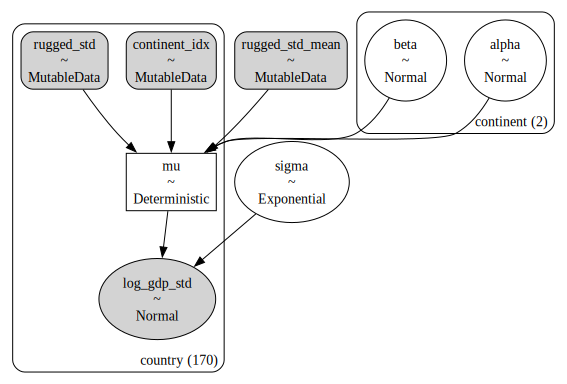

In [32]:
m8_3.to_graphviz()

And look at the posterior distributions

In [33]:
az.summary(
    trace_8_3,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[Not Africa],1.05,0.01,1.03,1.07
alpha[Africa],0.89,0.02,0.86,0.92
beta[Not Africa],-0.14,0.06,-0.23,-0.05
beta[Africa],0.13,0.08,0.01,0.25
sigma,0.11,0.01,0.10,0.12


Now we see that Africa has a positive slope, while outside of Africa has a negative slope.

Let's inspect the WAIC

In [34]:
az.compare(
    {
        "m8.1": trace_8_1b,
        "m8.2": trace_8_2,
        "m8.3": trace_8_3,
    },
    ic="waic",
    scale="deviance",
)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.3,0,-259.033411,5.070146,0.000000,0.865775,14.631536,0.000000,True,deviance
m8.2,1,-252.224855,4.178578,6.808556,0.134225,14.834728,6.458988,True,deviance
m8.1,2,-188.795587,2.610492,70.237824,0.000000,12.969212,14.913234,False,deviance


We again get warnings.

In [35]:
psis_8_3 = az.loo(trace_8_3, scale="deviance", pointwise=True)
waic_8_3 = az.waic(trace_8_3, scale="deviance", pointwise=True)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [36]:
psis_8_3

Computed from 4000 posterior samples and 170 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  -258.90    14.65
p_loo            5.14        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      170  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Again no warnings from PSIS

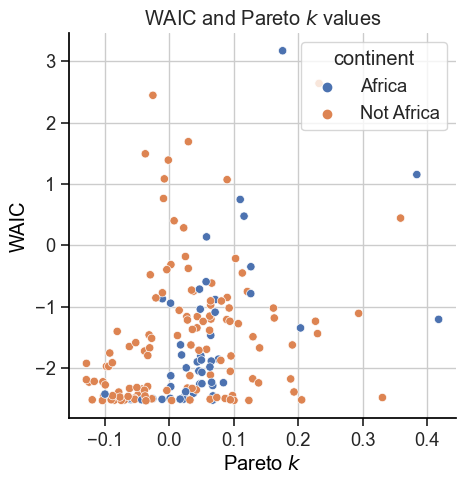

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    x=psis_8_3.pareto_k,
    y=waic_8_3.waic_i,
    hue=rugged["continent"],
    ax=ax,
)

ax.set(
    xlabel="Pareto $k$",
    ylabel="WAIC",
    title="WAIC and Pareto $k$ values",
);

### 8.1.4 Plotting the interaction

Let's plot the posteriors for the interaction model

In [38]:
# generate counterfactual ruggedness values
n_vals = 100
rugged_std_vals = np.linspace(0, 1, n_vals)

counterfactual_trace_8_3 = dict.fromkeys(continents)
with m8_3:
    for continent, continent_idx in continents_idx_mapper.items():
        pm.set_data(
            {
                "rugged_std": rugged_std_vals,
                "continent_idx": np.full(n_vals, continent_idx, dtype=int),
            },
            coords={
                "country": range(n_vals),
            },
        )
        counterfactual_trace_8_3[continent] = pm.sample_posterior_predictive(
            trace_8_3,
            var_names=["mu", "log_gdp_std"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

Sampling: [log_gdp_std]


Sampling: [log_gdp_std]


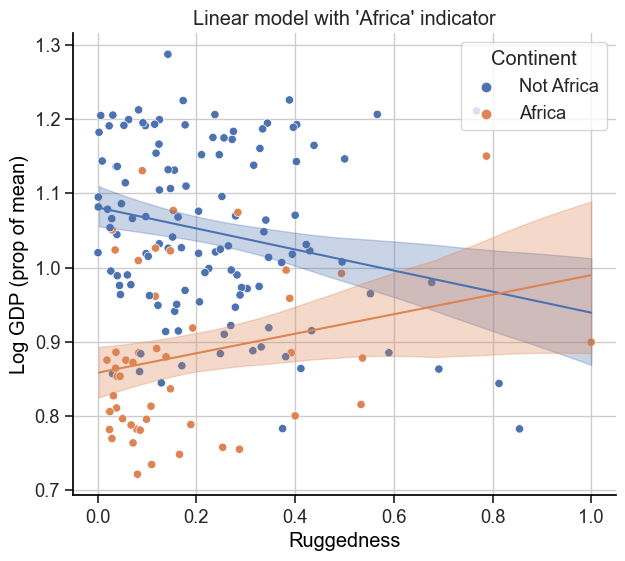

In [39]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.scatterplot(
    rugged,
    x="rugged_std",
    y="log_gdp_std",
    hue="continent",
    hue_order=continents,
    ax=ax,
)

for idx, (continent, trace) in enumerate(counterfactual_trace_8_3.items()):
    plot_posterior_linear_model(
        x=trace.predictions_constant_data.rugged_std,
        mu=trace.predictions.mu,
        smooth=True,
        color=colors[idx],
        ax=ax,
    )

ax.set(
    xlabel="Ruggedness",
    ylabel="Log GDP (prop of mean)",
    title="Linear model with 'Africa' indicator",
)
ax.legend(title="Continent");

## 8.2 Symmetry of interactions

Let's plot the effect of a country being in Africa on log GDP by terrain ruggedness.

In [40]:
mu_africa = counterfactual_trace_8_3["Africa"].predictions.mu
mu_not_africa = counterfactual_trace_8_3["Not Africa"].predictions.mu
mu_delta = mu_africa - mu_not_africa

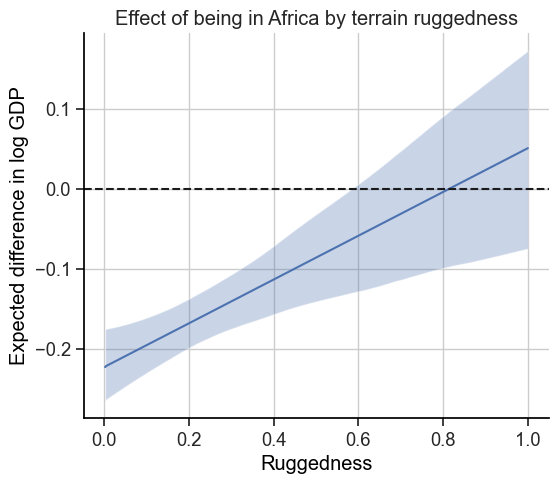

In [41]:
ax = plot_posterior_linear_model(
    x=counterfactual_trace_8_3["Africa"].predictions_constant_data.rugged_std,
    mu=mu_delta,
    smooth=True,
)
ax.axhline(0, color="k", ls="--")
ax.set(
    xlabel="Ruggedness",
    ylabel="Expected difference in log GDP",
    title="Effect of being in Africa by terrain ruggedness",
);

## 8.3 Continuous interactions

In [42]:
# load the data
tulips = load_data(TULIPS_FILE, delimiter=";")

# standardise variables
tulips["blooms_std"] = tulips["blooms"] / tulips["blooms"].mean()
tulips["water_cent"] = tulips["water"] - tulips["water"].mean()
tulips["shade_cent"] = tulips["shade"] - tulips["shade"].mean()

We start with a simple model with no interactions

In [43]:
coords = {
    "obs": tulips.index,
}
with pm.Model(coords_mutable=coords) as m8_4:
    # data
    water_cent = pm.MutableData("water_cent", tulips.water_cent, dims="obs")
    shade_cent = pm.MutableData("shade_cent", tulips.shade_cent, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0.5, sigma=0.25)
    beta_w = pm.Normal("beta_w", mu=0, sigma=0.25)
    beta_s = pm.Normal("beta_s", mu=0, sigma=0.25)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta_w * water_cent + beta_s * shade_cent, dims="obs"
    )

    # likelihood
    blooms_std = pm.Normal(
        "blooms_std", mu=mu, sigma=sigma, observed=tulips.blooms_std, dims="obs"
    )

    # inference
    trace_8_4 = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_w, beta_s, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


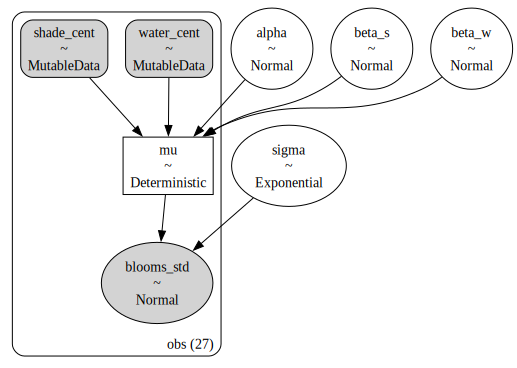

In [44]:
m8_4.to_graphviz()

Now a model with an interaction effect

In [45]:
coords = {
    "obs": tulips.index,
}
with pm.Model(coords_mutable=coords) as m8_5:
    # data
    water_cent = pm.MutableData("water_cent", tulips.water_cent, dims="obs")
    shade_cent = pm.MutableData("shade_cent", tulips.shade_cent, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0.5, sigma=0.25)
    beta_w = pm.Normal("beta_w", mu=0, sigma=0.25)
    beta_s = pm.Normal("beta_s", mu=0, sigma=0.25)
    beta_ws = pm.Normal("beta_ws", mu=0, sigma=0.25)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha
        + beta_w * water_cent
        + beta_s * shade_cent
        + beta_ws * water_cent * shade_cent,
        dims="obs",
    )

    # likelihood
    blooms_std = pm.Normal(
        "blooms_std", mu=mu, sigma=sigma, observed=tulips.blooms_std, dims="obs"
    )

    # inference
    trace_8_5 = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_w, beta_s, beta_ws, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Let's look at the posteriors

In [46]:
pm.summary(trace_8_4, var_names=["~mu"], kind="stats", hdi_prob=0.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.93,0.09,0.78,1.07
beta_w,0.48,0.11,0.31,0.66
beta_s,-0.26,0.11,-0.43,-0.08
sigma,0.50,0.08,0.38,0.62


In [47]:
pm.summary(trace_8_5, var_names=["~mu"], kind="stats", hdi_prob=0.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.95,0.08,0.83,1.08
beta_w,0.51,0.09,0.37,0.67
beta_s,-0.28,0.09,-0.42,-0.13
beta_ws,-0.33,0.11,-0.50,-0.16
sigma,0.41,0.07,0.30,0.50


The interaction model has similar posteriors for the main effect coefficients, but their narrower.
The interaction effect has negative coefficient which implies that as shade increases, the slope of water decreases.
It's hard to interpret more than that without plotting.

Just for fun let's compare the models with PSIS and WAIC.

In [48]:
az.compare(
    {
        "main_effects": trace_8_4,
        "interaction": trace_8_5,
    },
    ic="loo",
    scale="deviance",
)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
interaction,0,32.331627,4.402758,0.000000,1.0,6.776376,0.000000,False,deviance
main_effects,1,42.561989,3.523145,10.230361,0.0,7.341105,4.857051,False,deviance


As expected, the interaction model has better predictive performance.

Now let's build a triptych plot for different values of water, taking a sample of posterior lines.

In [49]:
def plot_tulips_posterior_samples_triptych(
    tulips,
    trace,
    x_name="water_cent",
    strat_name="shade_cent",
    n_lines=20,
    suptitle=None,
    axs=None,
):
    if axs is None:
        fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
    if suptitle is None:
        suptitle = f"Effect of {x_name} on blooms, stratified by {strat_name}"

    strat_vals = tulips[strat_name].sort_values().unique()
    for strat_val, ax in zip(strat_vals, axs):
        strat_mask = trace.constant_data[strat_name] == strat_val

        sns.scatterplot(
            tulips[strat_mask.data],
            x=x_name,
            y="blooms_std",
            ax=ax,
        )

        x_val = trace.constant_data[x_name].sel(obs=strat_mask).data
        ax.plot(
            np.repeat(x_val[:, np.newaxis], n_lines, axis=1),
            trace.posterior.mu.sel(chain=0, obs=strat_mask, draw=slice(n_lines - 1)).T,
            color="k",
            alpha=0.2,
        )

        ax.set(
            xlabel=x_name,
            title=f"{strat_name} = {int(strat_val)}",
        )

    axs[0].set(ylabel="Blooms")

    fig.suptitle(suptitle)
    fig.tight_layout()

    return axs

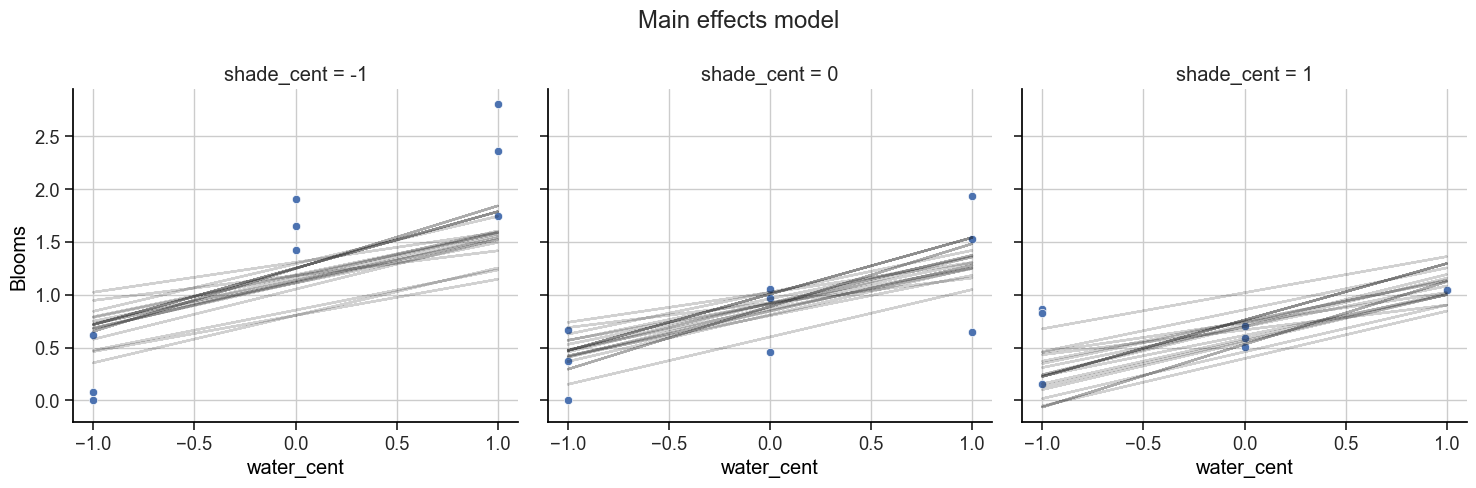

In [50]:
# main effects model
plot_tulips_posterior_samples_triptych(
    tulips,
    trace_8_4,
    x_name="water_cent",
    strat_name="shade_cent",
    suptitle="Main effects model",
);

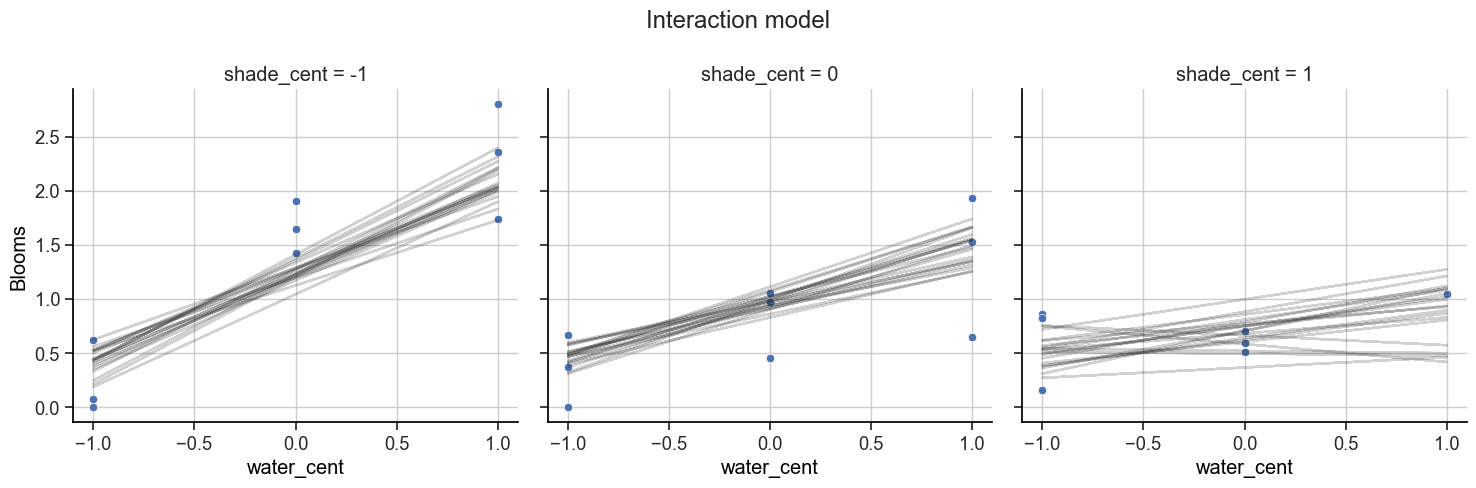

In [51]:
# interaction model
plot_tulips_posterior_samples_triptych(
    tulips,
    trace_8_5,
    x_name="water_cent",
    strat_name="shade_cent",
    suptitle="Interaction model",
);

We can also plot the effect of shade, stratified by water

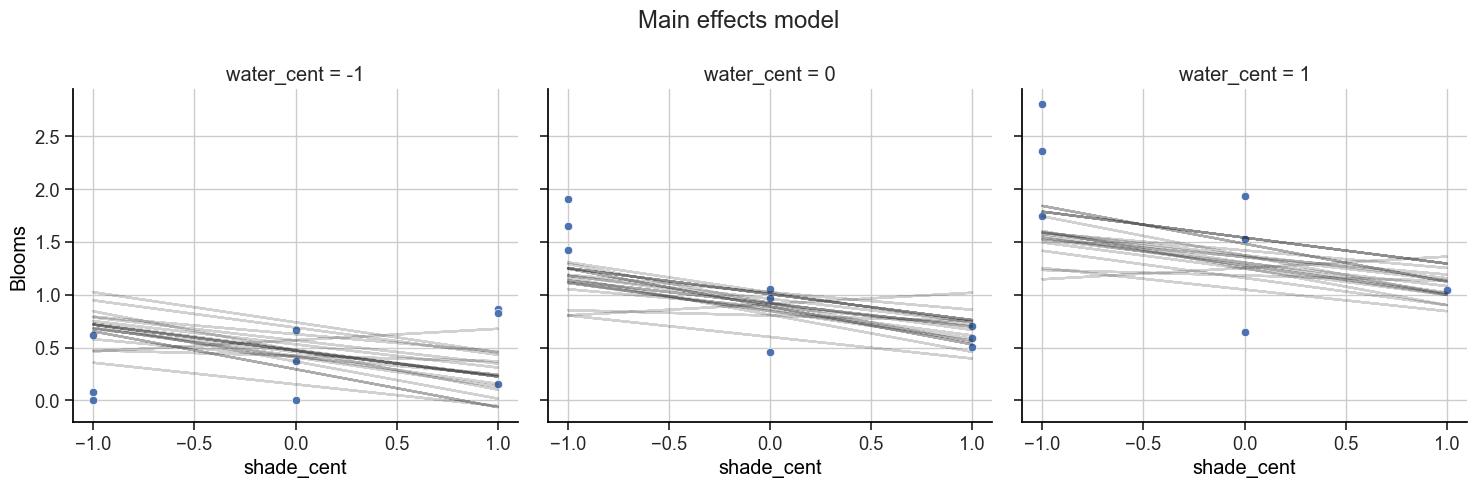

In [53]:
# main effects model
plot_tulips_posterior_samples_triptych(
    tulips,
    trace_8_4,
    x_name="shade_cent",
    strat_name="water_cent",
    suptitle="Main effects model",
);

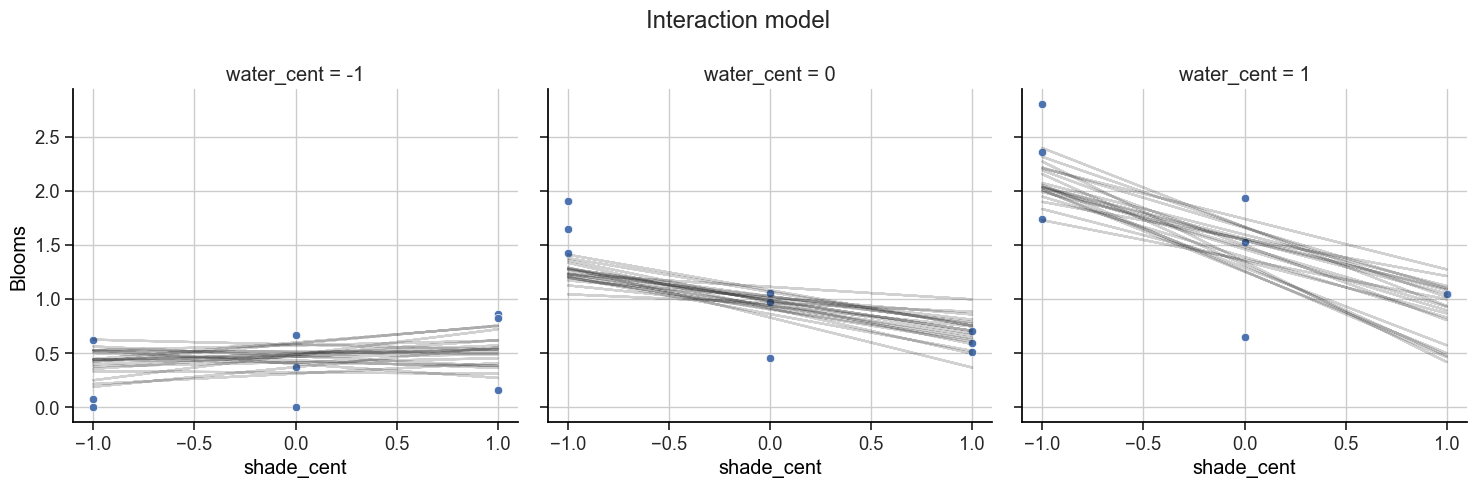

In [54]:
# interaction model
plot_tulips_posterior_samples_triptych(
    tulips,
    trace_8_5,
    x_name="shade_cent",
    strat_name="water_cent",
    suptitle="Interaction model",
);

We can also plot HDIs

In [55]:
def plot_tulips_hdi_triptych(
    tulips,
    trace,
    x_name="water_cent",
    strat_name="shade_cent",
    hdi_prob=0.89,
    suptitle=None,
    axs=None,
):
    if axs is None:
        fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
    if suptitle is None:
        suptitle = f"Effect of {x_name} on blooms, stratified by {strat_name}"

    strat_vals = tulips[strat_name].sort_values().unique()
    for strat_val, ax in zip(strat_vals, axs):
        strat_mask = trace.constant_data[strat_name] == strat_val

        sns.scatterplot(
            tulips[strat_mask.data],
            x=x_name,
            y="blooms_std",
            color=colors[0],
            ax=ax,
        )

        plot_posterior_linear_model(
            x=trace.constant_data[x_name].sel(obs=strat_mask),
            mu=trace.posterior.mu.sel(obs=strat_mask),
            smooth=True,
            hdi_prob=hdi_prob,
            color=colors[0],
            ax=ax,
        )

        ax.set(
            xlabel=x_name,
            title=f"{strat_name} = {int(strat_val)}",
        )

    axs[0].set(ylabel="Blooms")

    fig.suptitle(suptitle)
    fig.tight_layout()

    return axs

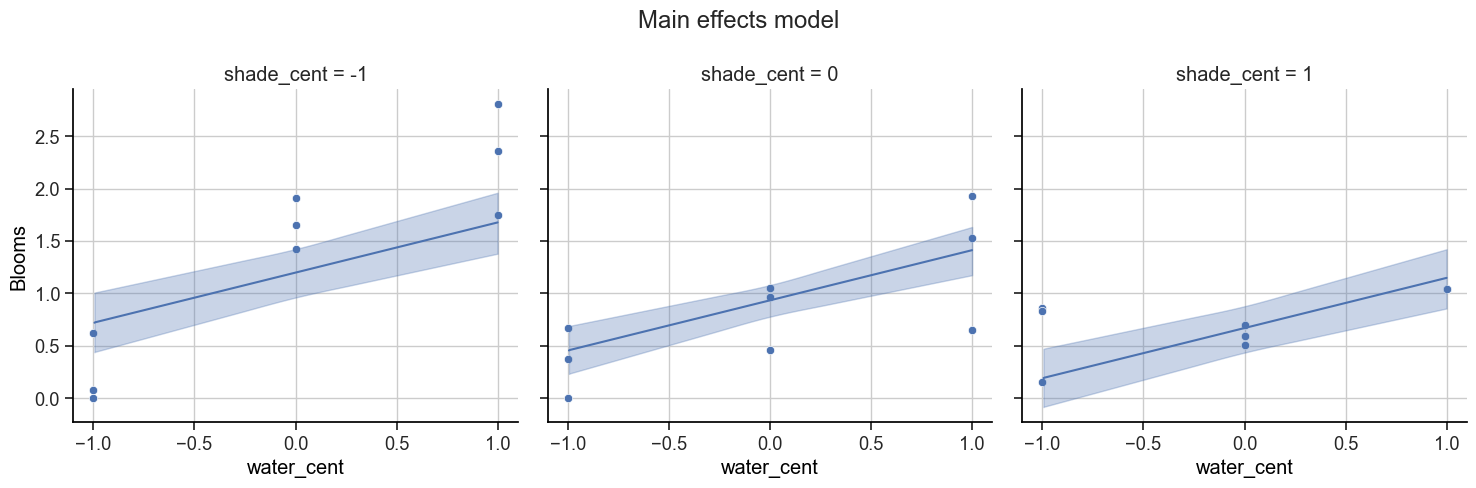

In [56]:
# main effects model
plot_tulips_hdi_triptych(
    tulips,
    trace_8_4,
    x_name="water_cent",
    strat_name="shade_cent",
    suptitle="Main effects model",
);

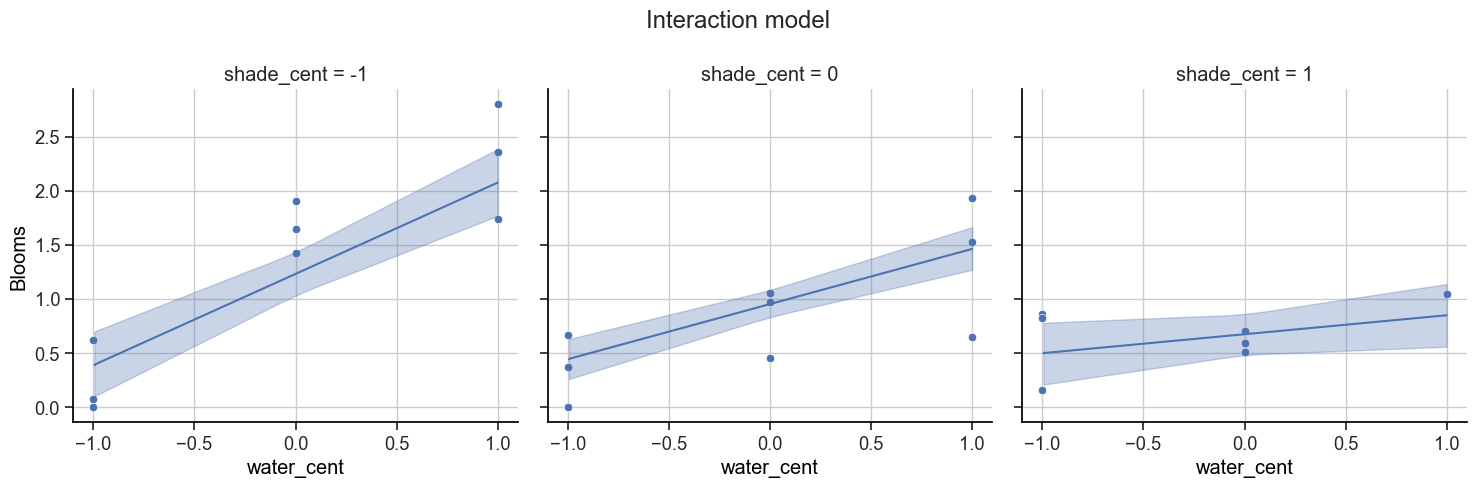

In [57]:
# interaction model
plot_tulips_hdi_triptych(
    tulips,
    trace_8_5,
    x_name="water_cent",
    strat_name="shade_cent",
    suptitle="Interaction model",
);

I don't think this really adds anything.